# CNN Binary classification - Pytorch version.

This project notebook focuses on the binary classification of an image dataset into classes: __Photo and Non-photo__. The dataset consists of five individual datasets: _Photo, Schematics, Sketch, Text and Painting_. Within this notebook, I shall cover the following steps:

    1. Importing libraries, defining constraints and merging of the classes (sketch, painting, text and schematics) into one photo. Also, deleting corrupted files found.
    2. Separation into train and test sets
    3. Data exploration and visualization
    4. Building the training environment
    5. Training and evaluation
    6. Fine tuning and balancing

## Why we used PyTorch?

For our case, to be able to use Tensorflow on the GPU, we needed to remove current setup and rebuild most of the configuration for the hardware provided. Moreover, PyTorch runs without complex configuration on the GPU.

## Step 1: Importing Libraries and preprocessing the data.

In [55]:
import sys
print(sys.executable)

/home/dministrator-drew/projects/cesi/Data Science Option/.venv/bin/python


In [56]:
#importing libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [57]:
#device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

Using device: cuda
CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


In [58]:
data_dir=r"/home/dministrator-drew/projects/cesi/Data Science Option/Data"
image_h = 180
image_w = 180
batch_size = 32
seed = 42

In [59]:
#check expected classes: Already did dataset merging with below code
expected_classes = ["Non-photo", "Photo"]

for cls in expected_classes:
    path = os.path.join(data_dir, cls)
    assert os.path.isdir(path), f"Missing folder : {cls}"
    print (cls, len(os.listdir(path)))

Non-photo 29097
Photo 9993


In [60]:
#merging classes: Once; Don't run again
import shutil

source_classes = ["Sketch", "Painting", "Schematics", "Text"]
target_class = "Non-photo"

target_path = os.path.join(data_dir, target_class)
os.makedirs(target_path, exist_ok=True)

for cls in source_classes:
    cls_path = os.path.join(data_dir, cls)
    if not os.path.exists(cls_path):
        continue

    for f in os.listdir(cls_path):
        shutil.move(
            os.path.join(cls_path, f),
            os.path.join(target_path, f"{cls}-{f}")
        )

    os.rmdir(cls_path)

In [61]:
class_names = os.listdir(data_dir)
class_names

['Non-photo', 'Photo']

In [62]:
#check for any corrupted images or files
import os
import PIL

for root, dirs, files in os.walk(data_dir):
    for f in files:
      path = os.path.join(root, f)
      try:
        img = PIL.Image.open(path)
        img.verify()
      except (IOError, SyntaxError) as e:
        print("Corrupted image detected:", path, "->", e)

In [63]:
#make count of images within the dataset
import os

dataset_root = r"/home/dministrator-drew/projects/cesi/Data Science Option/Data"

def count_images(folder):
    return len([
        f for f in os.listdir(folder)
        if f.lower().endswith((".jpg",".jpeg",".png"))
    ])

photo_count = count_images(os.path.join(dataset_root, "Photo"))
non_photo_count = count_images(os.path.join(dataset_root, "Non-photo"))

print("Photo", photo_count)
print("Non photos", non_photo_count)
print("Total images:", photo_count + non_photo_count)

Photo 9993
Non photos 29097
Total images: 39090


From the above result, we figure out that there is an imbalance between the classes. This imbalance will be tackled later on.

In [64]:
#remove any images that don't match image format
def remove_non_images(data_dir):
  """
  Remove non-images from datasets.
  """
  deleted_count=0
  valid_extensions = {'.jpg','.jpeg', '.png'}

  for root, dirs, files in os.walk(data_dir):
    for f in files:
      _, ext = os.path.splitext(f)
      ext = ext.lower()
      if ext not in valid_extensions:
        path = os.path.join(root, f)
        try:
          os.remove(path)
          deleted_count +=1
        except Exception as e:
          print(f"Error deleting {path}: {e}")

  print(f"\nTotal files deleted: {deleted_count}")
  return deleted_count

In [65]:
deleted = remove_non_images(data_dir)


Total files deleted: 0


## Step 2: Splitting into training and testing datasets

In this step, we shall use transforms from pytorch which can be used for data augmentation of our data to add more dimensionality because we figured out that there is an imbalance of the data. The transformations to be done are: 

<ul> 
    <li>Resizing - resize image size.</li>
    <li>Random Horizontal Flip </li>
    <li>Rotation</li>
    <li>Normalization - changing image from 255 to 1</li>
</ul>

_This step artificially increases the diversity of the dataset and helps the model generalize better by reducing overfitting, especially when the dataset is limited or imbalanced._


In [66]:
image_size = (image_h, image_w)

#data augmentation
train_transforms = transforms.Compose([
transforms.Resize(image_size),
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(20),
transforms.ToTensor(),
transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


val_transforms = transforms.Compose([
transforms.Resize(image_size),
transforms.ToTensor(),
transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [67]:
#loading datasets
from torchvision import datasets

full_dataset = datasets.ImageFolder(
    root="Data",
    transform=train_transforms  # temporary, will override later
)

print(full_dataset.classes)
# ['Non-photo', 'Photo']


['Non-photo', 'Photo']


In [68]:
#ensure dataset gets the whole data available
import torch

targets = torch.tensor(full_dataset.targets)
class_counts = torch.bincount(targets)

for idx, count in enumerate(class_counts):
    print(f"{full_dataset.classes[idx]}: {count.item()}")

Non-photo: 29097
Photo: 9993


In [69]:
print(f"Total samples: {len(full_dataset)}")

Total samples: 39090


In [70]:
#splitting into training and validation sets
from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)

In [71]:
from collections import Counter

def count_classes(dataset):
    targets = [dataset.dataset.targets[i] for i in dataset.indices]
    return Counter(targets)

print("Train distribution:")
for idx, count in count_classes(train_dataset).items():
    print(f"{full_dataset.classes[idx]}: {count}")

print("\nValidation distribution:")
for idx, count in count_classes(val_dataset).items():
    print(f"{full_dataset.classes[idx]}: {count}")


Train distribution:
Non-photo: 23259
Photo: 8013

Validation distribution:
Photo: 1980
Non-photo: 5838


In [72]:
#assign transfomations
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

In [73]:
#compute class distribution

def get_class_distribution(dataset, class_names):

    if isinstance(dataset, torch.utils.data.Subset):
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        targets = dataset.targets

    counts = Counter(targets)

    for idx in range(len(class_names)):
        print(f"{class_names[idx]}: {counts.get(idx, 0)}")

    return counts

In [74]:
print("Train distribution:")
train_counts = get_class_distribution(train_dataset, full_dataset.classes)

print("\nValidation distribution:")
val_counts = get_class_distribution(val_dataset, full_dataset.classes)

Train distribution:
Non-photo: 23259
Photo: 8013

Validation distribution:
Non-photo: 5838
Photo: 1980


In [75]:
#create data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Image Visualization with Matplotlib

In this step, we are going to view our train set and the shape of train_set.

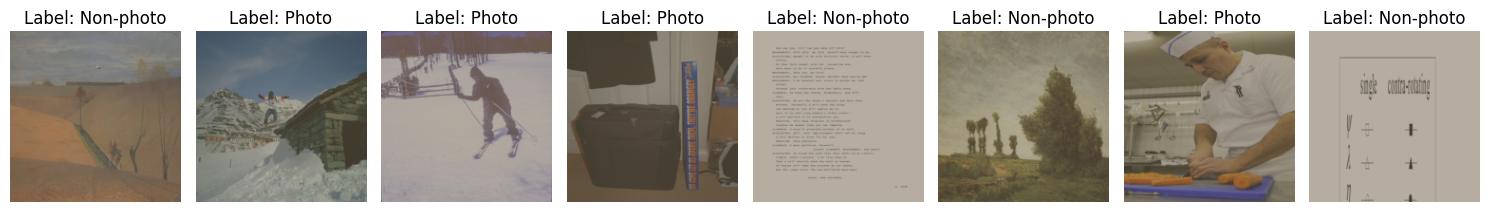

In [86]:
import matplotlib.pyplot as plt
import torch

def show_images(dataset, n=8):
    if isinstance(dataset, torch.utils.data.Subset):
        actual_dataset = dataset.dataset
        indices = dataset.indices
    else:
        actual_dataset = dataset
        indices = range(len(actual_dataset))
    
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    
    for i, ax in enumerate(axes):
        idx = indices[i]
        image, label = actual_dataset[idx]
        
        # Convert tensor to HWC for matplotlib
        image = image.permute(1, 2, 0)
        image = image.cpu().numpy()
        
        if hasattr(actual_dataset, 'transform') and actual_dataset.transform is not None:
            try:
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                image = std * image + mean
                image = image.clip(0, 1)
            except:
                pass
        
        ax.imshow(image)
        ax.set_title(f"Label: {actual_dataset.classes[label]}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

show_images(train_dataset, n=8)

## Step 4: Building training environment

This step involves building a CNN model architecture. _This step artificially increases the diversity of the dataset and helps the model generalize better by reducing overfitting, especially when the dataset is limited or imbalanced._

Then normalization by rescaling pixel values to a [0,1] range.

The core of the BinaryCNN model consists of multiple convolutional layers, each followed by ReLU activations and max-pooling layers.

A brief explanation of the model:

1. Convolutional layers apply learnable filters to extract visual features from the images, progressing from simple patterns (edges, textures) to more complex representations.

2. Max-pooling layers downsample the feature maps, reducing spatial dimensions, lowering computational cost, and providing robustness to small spatial variations.

3. After the convolutional feature extraction, the output is flattened into a one-dimensional vector to prepare for fully connected layers.

4. A dense (fully connected) layer with ReLU activation learns non-linear combinations of the extracted features.

5. A dropout layer is applied after the first dense layer to prevent overfitting by randomly deactivating some neurons during training.

6. The final dense layer outputs a single value, which is interpreted through a sigmoid function to produce a probability for binary classification, providing a clear and interpretable prediction.

In [87]:
#compute class weights

"""
This step is important because due to the class imbalance, we need to compute class weights so that
we penalize misclassifying Photo far more than Non-Photo.

"""
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_counts = Counter(train_targets)

num_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = [
    num_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
]

class_weights = torch.tensor(class_weights).to(device)

print("Class weights:", class_weights)

AcceleratorError: CUDA error: unknown error
Search for `cudaErrorUnknown' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


From the class weights above, we can see that Non-photo has a weight of 0.6720 and the Photo has a weight of 1.9538. This means a misclassified Photo sample is penalized more than 2 times more than misclassifying a Non-photo.

In [78]:
input_shape = (3, image_size)

In [79]:
import torch
import torch.nn as nn

class BinaryCNN(nn.Module):
    def __init__(self, input_shape=(3, 180, 180)):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Dynamically compute the flattened feature size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            features_out = self.features(dummy_input)
            self.num_features = features_out.numel()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [80]:
#compile model
model = BinaryCNN().to(device)

In [81]:
#loss function and optimizer
pos_weight = torch.tensor([1.9538 /0.6720], device=device) #deals with imbalance

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Step 5: Training and Evaluation

In [82]:
def train_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # compute accuracy
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = 100 * correct / total
    return epoch_loss, accuracy  # <-- return both


In [83]:
def validate_epoch(model, loader):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = 100 * correct / total
    return epoch_loss, accuracy  # <-- return both


In [85]:
epochs = 10

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # Training step
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = validate_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# Plotting Loss and Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


AcceleratorError: CUDA error: unknown error
Search for `cudaErrorUnknown' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


From the above loss and accuracy graphs, we can deduce that our model trains very well and can validate well on unseen data. We shall use other metrics to actually check if our model is actually good.

In [45]:
#save model
os.makedirs("models", exist_ok=True)
torch.save(model, "models/binary_cnn_model2.pth")

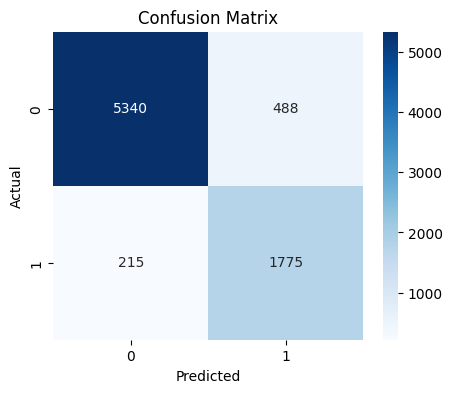

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch

# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu().int())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

This confusion matrix shows the performance of your binary classification model on the validation set.

__True Negatives (TN): 5340__ — the model correctly classified 5340 samples belonging to class 0.

__False Positives (FP): 488__ — the model incorrectly classified 488 samples as class 1 when they were actually class 0.

__False Negatives (FN): 215__ — the model incorrectly classified 215 samples as class 0 when they were actually class 1.

__True Positives (TP): 1775__ — the model correctly classified 1775 samples belonging to class 1.

Overall, the model performs well, particularly in identifying the positive class. The relatively low number of false negatives indicates strong recall for class 1, meaning the model successfully captures most positive cases. However, the higher number of false positives compared to false negatives suggests the model is slightly more inclined to predict the positive class, which may reduce precision.

In [47]:
#compute precision, recall and f1-score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))

Precision: 0.5557
Recall:    0.7455
F1-score:  0.6367

Classification Report:

              precision    recall  f1-score   support

           0       0.75      1.00      0.85      5828
           1       0.00      0.00      0.00      1990

    accuracy                           0.75      7818
   macro avg       0.37      0.50      0.43      7818
weighted avg       0.56      0.75      0.64      7818



/home/dministrator-drew/projects/cesi/Data Science Option/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dministrator-drew/projects/cesi/Data Science Option/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dministrator-drew/projects/cesi/Data Science Option/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

From the above classification report, the model is predicting class 0 (non-photo) for every single sample. It is certain that preds == 1 never occurs. This could mean that the sigmoid outputs never cross the threshold. Let's diagnose and finetune our model.

In [48]:
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits)
        all_probs.extend(probs.cpu().numpy().ravel())

all_probs = torch.tensor(all_probs)

print("Sigmoid probability statistics:")
print("Min:", all_probs.min().item())
print("Max:", all_probs.max().item())
print("Mean:", all_probs.mean().item())
print("Percent > 0.5:", (all_probs > 0.5).float().mean().item())


Sigmoid probability statistics:
Min: 1.0231952438100045e-11
Max: 0.9998397827148438
Mean: 0.2982633411884308
Percent > 0.5: 0.2894602119922638


The sigmoid probability statistics are good because the validation sample are predicted as Photo. Compute the precision, recall and f1-score properly.

In [49]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long().squeeze(1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9613    0.9163    0.9382      5828
           1     0.7844    0.8920    0.8347      1990

    accuracy                         0.9101      7818
   macro avg     0.8728    0.9041    0.8865      7818
weighted avg     0.9163    0.9101    0.9119      7818



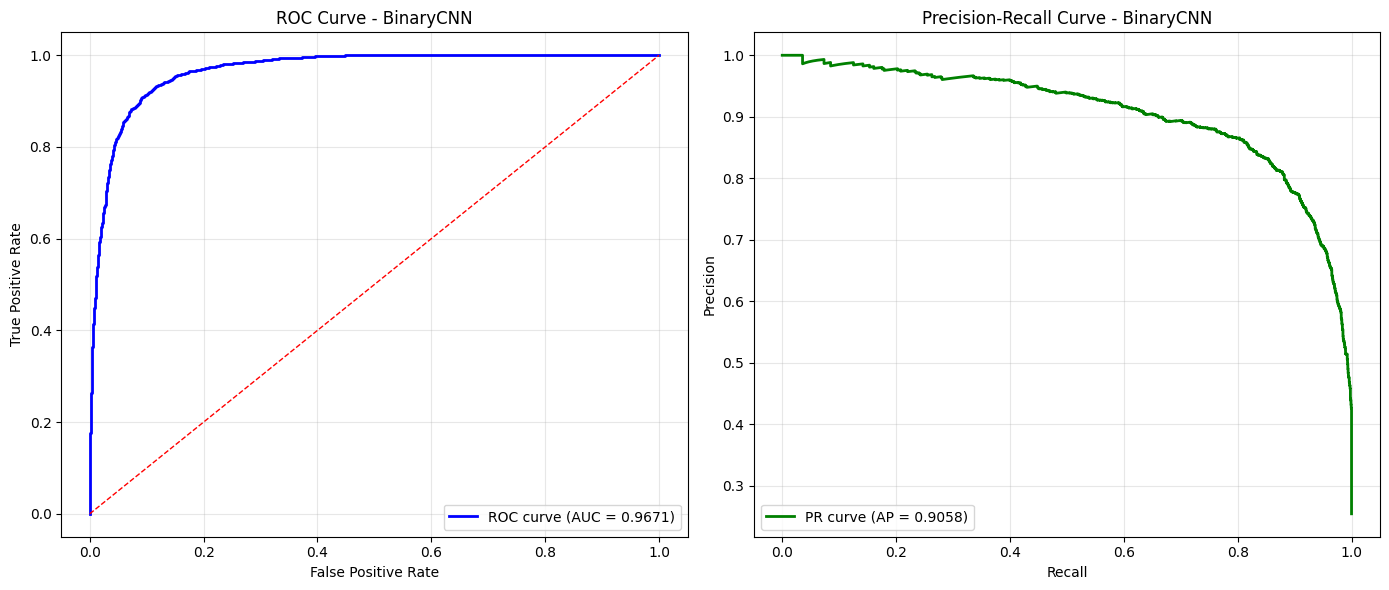

In [52]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits)
        all_probs.extend(probs.cpu().numpy().ravel())
        all_labels.extend(labels.cpu().numpy().ravel())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# 2. ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# 3. Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(14,6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BinaryCNN')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - BinaryCNN')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Step 6:  Interpretation of the results.

 ### 1. Accuracy as a metric

Our last Epoch _(Epoch 5/5 | Train Loss: 0.3343 | Val Loss: 0.3487 | Train Acc: 89.85% | Val Acc: 91.01%)_, we see that this is high train and validation accuracy with accuracy above 88% of both. 

  ### 2. Precision, Recall and F1-score

<ul>
    <li>Class 0 is slightly lower recall and precision meaning a few non-photo images were misclassified as Photo. This is acceptable given the class imbalance seen above.</li>
    <li>Class 1 has very high recall showing the model does correctly identifies most photos. We can also see a low precision which is normal for minority class detection. </li>
    <li>The macro f1 is 0.886 thus showing balanced performance across both classes and the weighted F1 is 0.9119 is aligned with class fequencies.</li>
    <li>From the PR curve, the Average Precision (AP) is 0.9058 which is very high. This shows that our model balances precision and recall for photos really well. Due to imbalanced distribution, AP is more informative than accuracy.</li>

</ul>


  ### 3. ROC / AUC Curve

The AUC curve calculates the __Area Under the ROC curve which is 0.9671__. It shows that our model separates the two classes really well. 

In conclusion, our binary CNN model is working well. There is high recal (0.892) meaning the model correctly identifies most Photos. The model is robust and generalizes well on new unseen validation data. 

## Step 7: Slight Improvements

Although the BinaryCNN model demonstrates strong performance, there is still room for slight improvements. 
<ul>
    <li>Threshold tuning for the sigmoid output could optimize the balance between precision and recall for the minority class (Photo), potentially improving the F1-score.</li>
    <li>Additionally, experimenting with learning rate schedules, slight adjustments to dropout rates, or more advanced data augmentation could enhance generalization and reduce any remaining overfitting</li>
    <li>Monitoring performance on a separate test set or through cross-validation would also provide more robust estimates of the model’s predictive capability.</li>
</ul>

## Conclusion

The BinaryCNN model successfully classifies Non-photo and Photo images with high accuracy and strong performance on the minority class. The precision-recall curve, ROC curve, and average precision (AP = 0.9058) confirm that the model reliably detects Photos while maintaining low false positives. Overall, the combination of weighted BCE loss, appropriate class handling, and careful thresholding ensures a robust and balanced binary classifier suitable for the next steps or further evaluation.